M54 via MCMC
------------

Okay, let's check how SVD-MCMC performs on M54-data.

First, we load the precomputed samples.


In [9]:
import numpy as np

samples = np.load("out/m54_samples_q15.npy")
samples.shape

(1000, 636)

So, 1000 samples. Should be enough for the beginning.

Let's look at some samples:


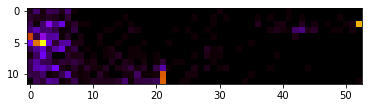

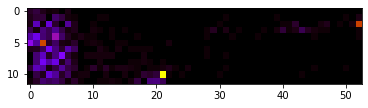

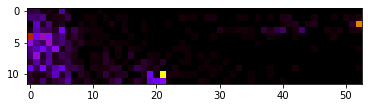

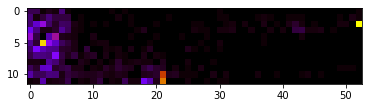

In [10]:
from matplotlib import pyplot as plt
%matplotlib inline

N = samples.shape[0]
random_indices = np.random.randint(low=0, high=N, size=4)
random_samples = samples[random_indices]

for sample in random_samples:
    f = sample.reshape(12, 53)

    plt.imshow(f, cmap="gnuplot")
    plt.show()


Let's also look at the posterior geometric median:

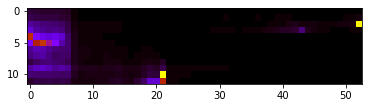

In [11]:
from src.comparison.geometric_median import geometric_median

posterior_median = geometric_median(X=samples).reshape(12, 53)
plt.imshow(posterior_median, cmap="gnuplot")
plt.show()

Look's more or less the same, except maybe a little bit smoother.

Now, it's time for some uncertainty quantification. We start with computing the
stack of FCIs.

In [12]:
from src.m54.m54_fit_model import m54_fit_model

sigma_list = [np.array([0.5 * s, s]) for s in range(1, 20, 1)]
fitted_model = m54_fit_model()
lower_stack, upper_stack = fitted_model.compute_fci_stack_from_samples(sigma_list=sigma_list,
                                                                       samples=samples)



Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 

Fit using PPXF...
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:       146         3    -0.088     0.187
chi2/DOF: 0.9353; degree = -1; mdegree = 21
method = capfit; Jac calls: 9; Func calls: 241; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  22 / 636
Rescale data...
SNR = 92.12754404263998
Perform MAP estimation...
Distribution functions should have shape (12, 53)




Starting the constrained Gauss-Newton method. Cost at starting value: 125.74564507691528
+-----------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+
| Iteration | Cost                    | Constraint violation    | Stepsize (||p||)        | Steplength (h)          | Computation time [s]    |
+-----------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+
+-----------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+
|     1     |    0.5498549656733599   |  3.798393891085716e-15  |   0.26639213918977933   |           1.0           |    1.0224003791809082   |
+-----------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+
|     2     |    0.5498549656733593   |  3.95

Compute FCI for sigma=[0.5 1. ].
Compute FCI for sigma=[1. 2.].
Compute FCI for sigma=[1.5 3. ].
Compute FCI for sigma=[2. 4.].
Compute FCI for sigma=[2.5 5. ].
Compute FCI for sigma=[3. 6.].
Compute FCI for sigma=[3.5 7. ].
Compute FCI for sigma=[4. 8.].
Compute FCI for sigma=[4.5 9. ].
Compute FCI for sigma=[ 5. 10.].
Compute FCI for sigma=[ 5.5 11. ].
Compute FCI for sigma=[ 6. 12.].
Compute FCI for sigma=[ 6.5 13. ].
Compute FCI for sigma=[ 7. 14.].
Compute FCI for sigma=[ 7.5 15. ].
Compute FCI for sigma=[ 8. 16.].
Compute FCI for sigma=[ 8.5 17. ].
Compute FCI for sigma=[ 9. 18.].
Compute FCI for sigma=[ 9.5 19. ].


Using this stack, we can now determine which blobs are 99%-significant:

In [15]:
from uq4pk_fit.blob_detection.significant_blobs.detect_significant_blobs import detect_significant_blobs

alpha = 0.01
# Have to rescale, since everything is so large.
vmax = upper_stack.max()
lower_stack = lower_stack / vmax
upper_stack = upper_stack / vmax
posterior_median = posterior_median / vmax
significant_blobs = detect_significant_blobs(reference=posterior_median,
                                             sigma_list=sigma_list,
                                             lower_stack=lower_stack,
                                             upper_stack=upper_stack,
                                             rthresh1=0.01,
                                             rthresh2=0.01,
                                             overlap1=0.5,
                                             overlap2=0.2)



I am here.
Computing blanket stack.
Evaluating Laplacian of blanket stack.


Let's visualize the results.

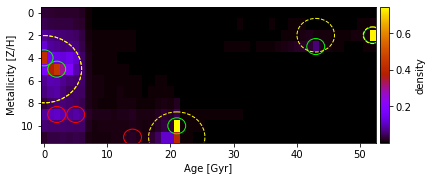

In [16]:
from uq4pk_fit.visualization import plot_significant_blobs
%matplotlib inline

plot_significant_blobs(image=posterior_median, blobs=significant_blobs, show=True)



Very confident, aren't we? Especially for the right-most clump, I would expect a little bit more
uncertainty.
